# Pulsar Star Predictor

*Group 006-35: Rapeewit Chanprakaisi, Arav Dewan, Serena Khatwa, Mike Zhang*

## Introduction

A pulsar star is a highly magnetized rotating neutron star which emits electromagnetic radiation beams out of its magnetic poles. Electromagnetic waves produce a detectable pattern of broadband radio emission. However, detection of a pulsar in reality is challenging because radio frequency interferences and radio noise often trigger the detectors and mimic the pulsar star. In this project, we will answer the following question:

*Using our prediction model, how accurately can we predict whether or not a signal is from a pulsar star?*

We will be using the HTRU2 data set which contains pulsar candidates collected during the High Time Resolution Universe Survey to conduct our study. The HTRU2 dataset contains 17898 examples out of which 1639 are real pulsar examples. Each observation is described by 8 continuous variables, and a single class variable. The first 4 are mean, standard deviation, excess kurtosis, and skewness obtained from the integrated pulse profile, while the other 4 are from the DM-SNR curve.

## Preliminary exploratory data analysis

Loading in libaries.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Reading

Reading the data set from the web.

In [2]:
pulsar_data <- read_csv("https://raw.githubusercontent.com/rchanpra/dsci100_group_project/main/HTRU2/HTRU_2.csv",
                        col_names = FALSE)
set.seed(1234)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling

Adding column names.

In [3]:
colnames(pulsar_data) <- c("mean_profile",
                           "deviation_profile",
                           "kurtosis_profile",
                           "skewness_profile",
                           "mean_dmsnr",
                           "deviation_dmsnr",
                           "kurtosis_dmsnr",
                           "skewness_dmsnr",
                           "class")

Renaming values and factoring the `class` variable.

In [16]:
pulsar_data <- pulsar_data |>
    mutate(class = ifelse(class == 1, "pulsar", "non_pulsar")) |>
    mutate(class = as_factor(class))

The data set is now tidy.

In [6]:
pulsar_data |> head(6)

mean_profile,deviation_profile,kurtosis_profile,skewness_profile,mean_dmsnr,deviation_dmsnr,kurtosis_dmsnr,skewness_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,non_pulsar
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,non_pulsar
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,non_pulsar
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,non_pulsar
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,non_pulsar
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,non_pulsar


### Splitting

Splitting into the dataset into training and testing data.

In [17]:
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

### Summarizing

Determining the number of rows that has missing data.

In [8]:
pulsar_train |> is.na() |> sum()

[1] 0

Finding the mean of each continuous variables.

In [9]:
pulsar_train |> select(!class) |> map_df(mean)

mean_profile,deviation_profile,kurtosis_profile,skewness_profile,mean_dmsnr,deviation_dmsnr,kurtosis_dmsnr,skewness_dmsnr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
110.9648,46.5201,0.4799091,1.77279,12.68089,26.30168,8.311861,104.9183


Finding the count of each value in class.

In [10]:
pulsar_train |> group_by(class) |> summarize(n = n())

class,n
<fct>,<int>
non_pulsar,12193
pulsar,1230


Alternatively, we can also use the `summary()` function.

In [11]:
pulsar_train |> summary()

  mean_profile     deviation_profile kurtosis_profile   skewness_profile 
 Min.   :  5.812   Min.   :24.77     Min.   :-1.73078   Min.   :-1.7919  
 1st Qu.:100.820   1st Qu.:42.34     1st Qu.: 0.02808   1st Qu.:-0.1882  
 Median :115.047   Median :46.92     Median : 0.22403   Median : 0.2019  
 Mean   :110.965   Mean   :46.52     Mean   : 0.47991   Mean   : 1.7728  
 3rd Qu.:127.062   3rd Qu.:51.02     3rd Qu.: 0.47363   3rd Qu.: 0.9255  
 Max.   :190.422   Max.   :98.78     Max.   : 8.06952   Max.   :68.1016  
   mean_dmsnr       deviation_dmsnr  kurtosis_dmsnr   skewness_dmsnr    
 Min.   :  0.2132   Min.   :  7.37   Min.   :-2.812   Min.   :  -1.977  
 1st Qu.:  1.9160   1st Qu.: 14.42   1st Qu.: 5.808   1st Qu.:  35.487  
 Median :  2.7893   Median : 18.41   Median : 8.453   Median :  83.421  
 Mean   : 12.6809   Mean   : 26.30   Mean   : 8.312   Mean   : 104.918  
 3rd Qu.:  5.3921   3rd Qu.: 28.23   3rd Qu.:10.718   3rd Qu.: 139.965  
 Max.   :223.3921   Max.   :110.64   Max.   

## Finding Predictor Variables

For the sake of simplicity, we will use 4 predictor variables from either the integrated pulse profile or the DM-SNR curve. 

We will capitalize on the `ggpairs()` function from the `GGally` library to plot the variables against each other with class as the color.

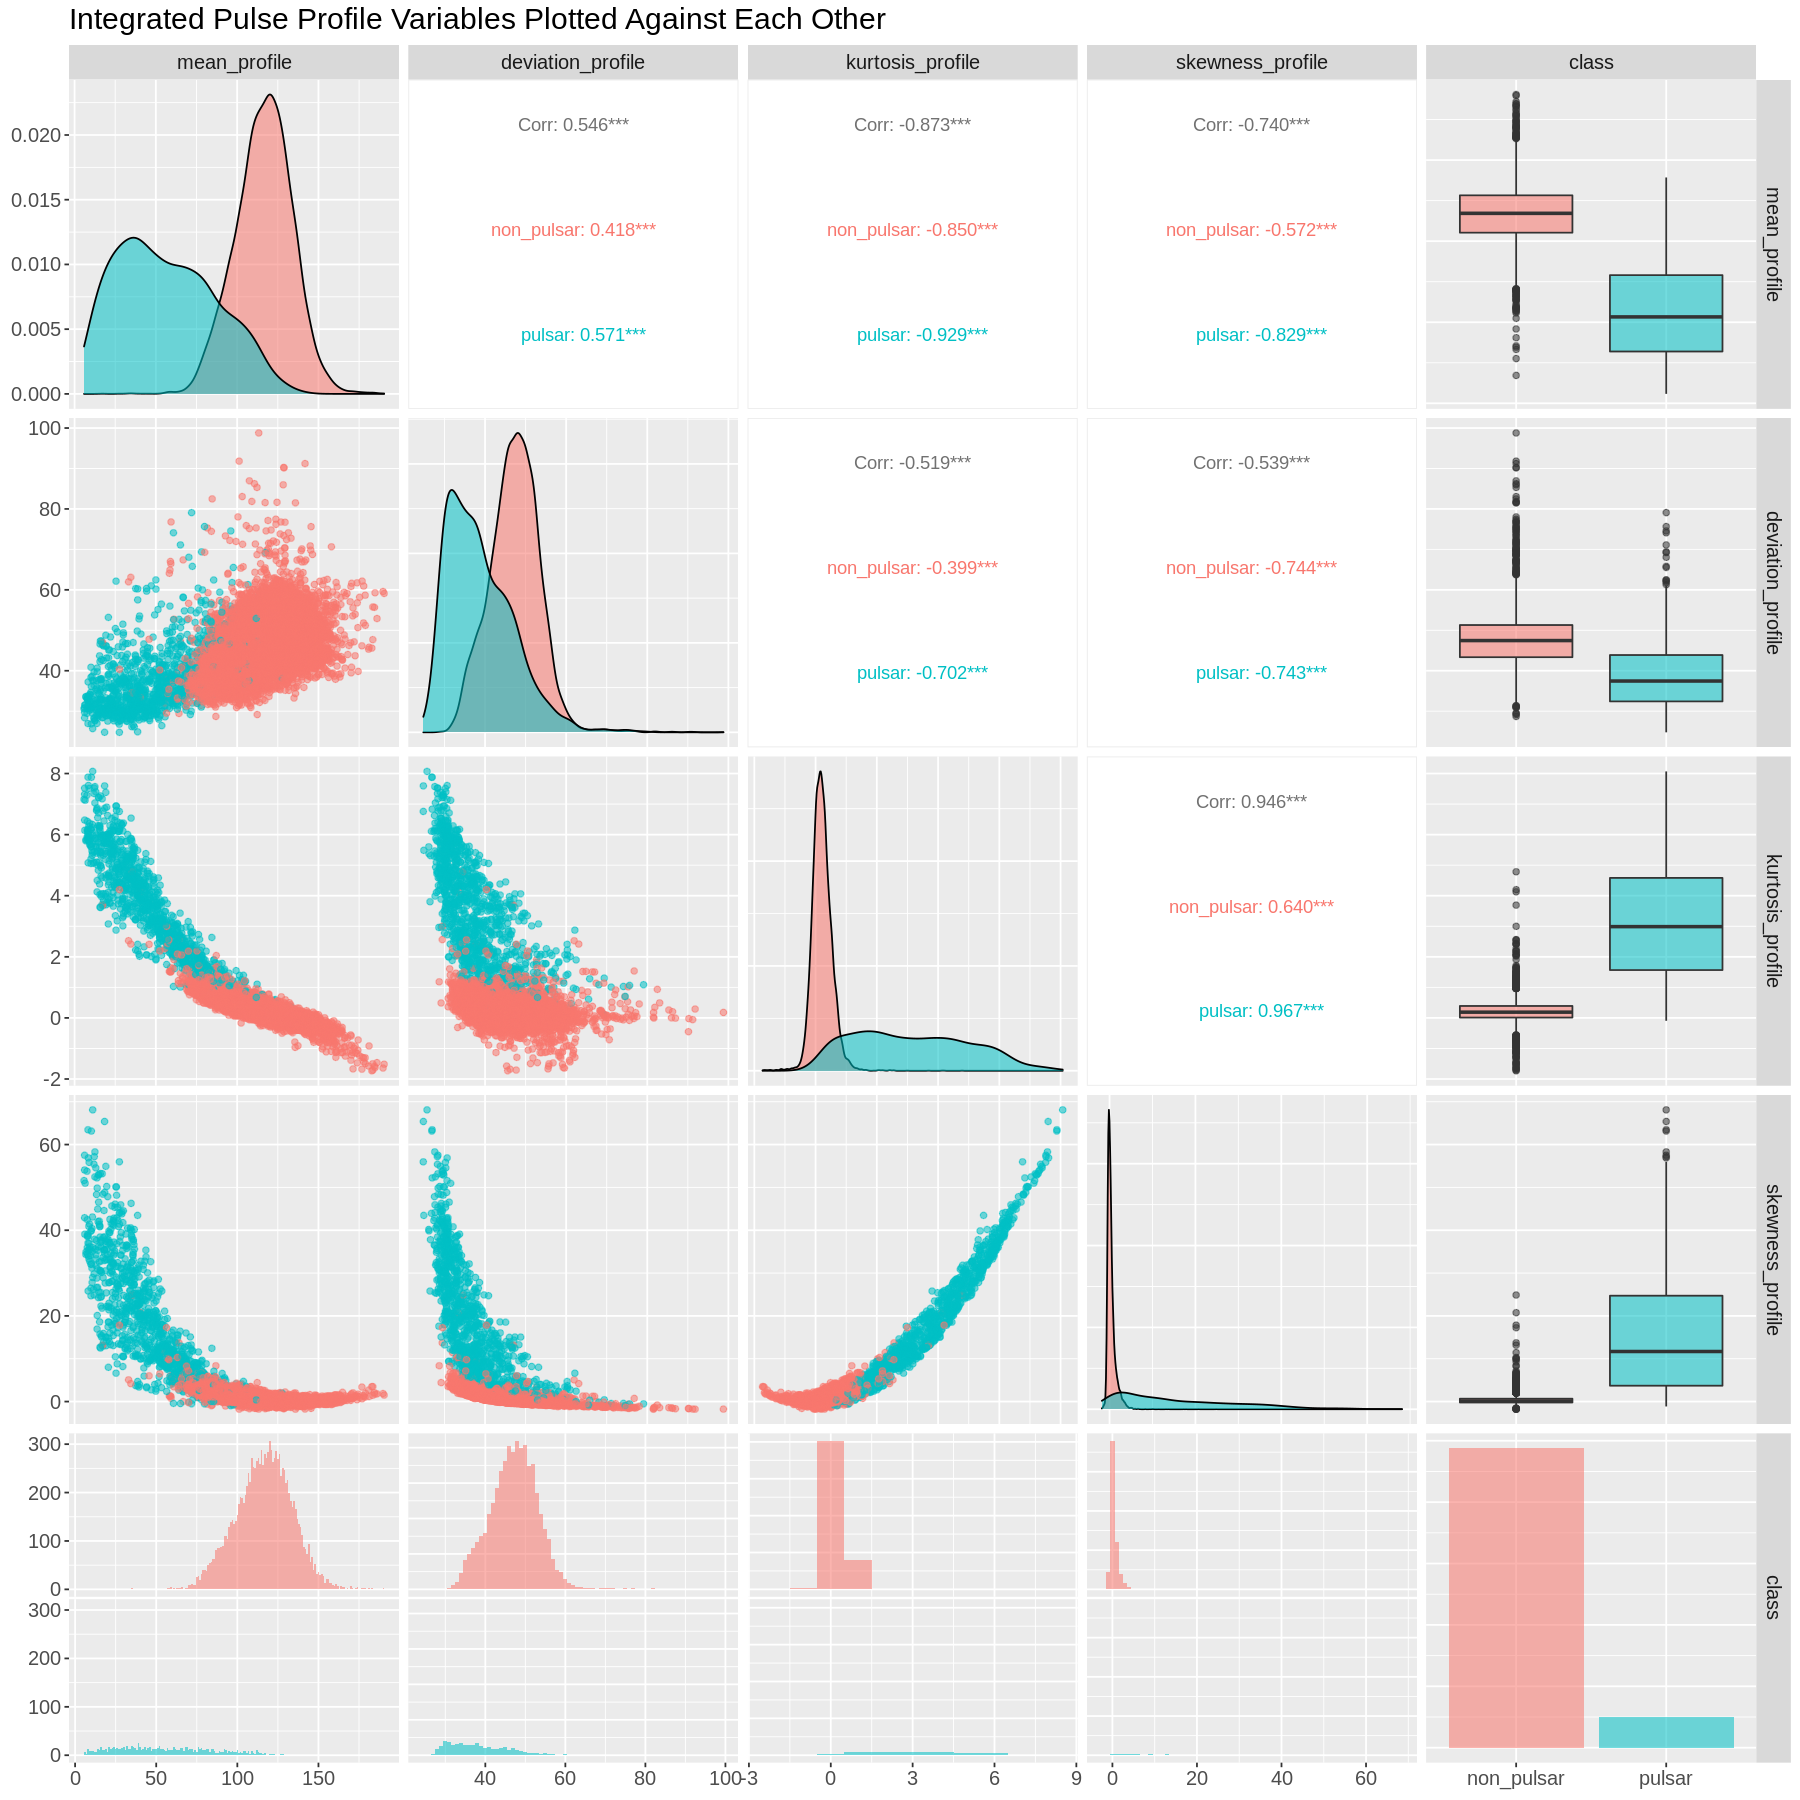

In [12]:
options(repr.plot.width = 15, repr.plot.height = 15)

pulsar_train_profile_plot <- pulsar_train |>
    select(!mean_dmsnr:skewness_dmsnr) |>
    ggpairs(aes(color = class, alpha = 0.5),
            lower = list(combo = wrap("facethist", binwidth = 1))) +
    labs(title = "Integrated Pulse Profile Variables Plotted Against Each Other") +
    theme(text = element_text(size = 15))
pulsar_train_profile_plot

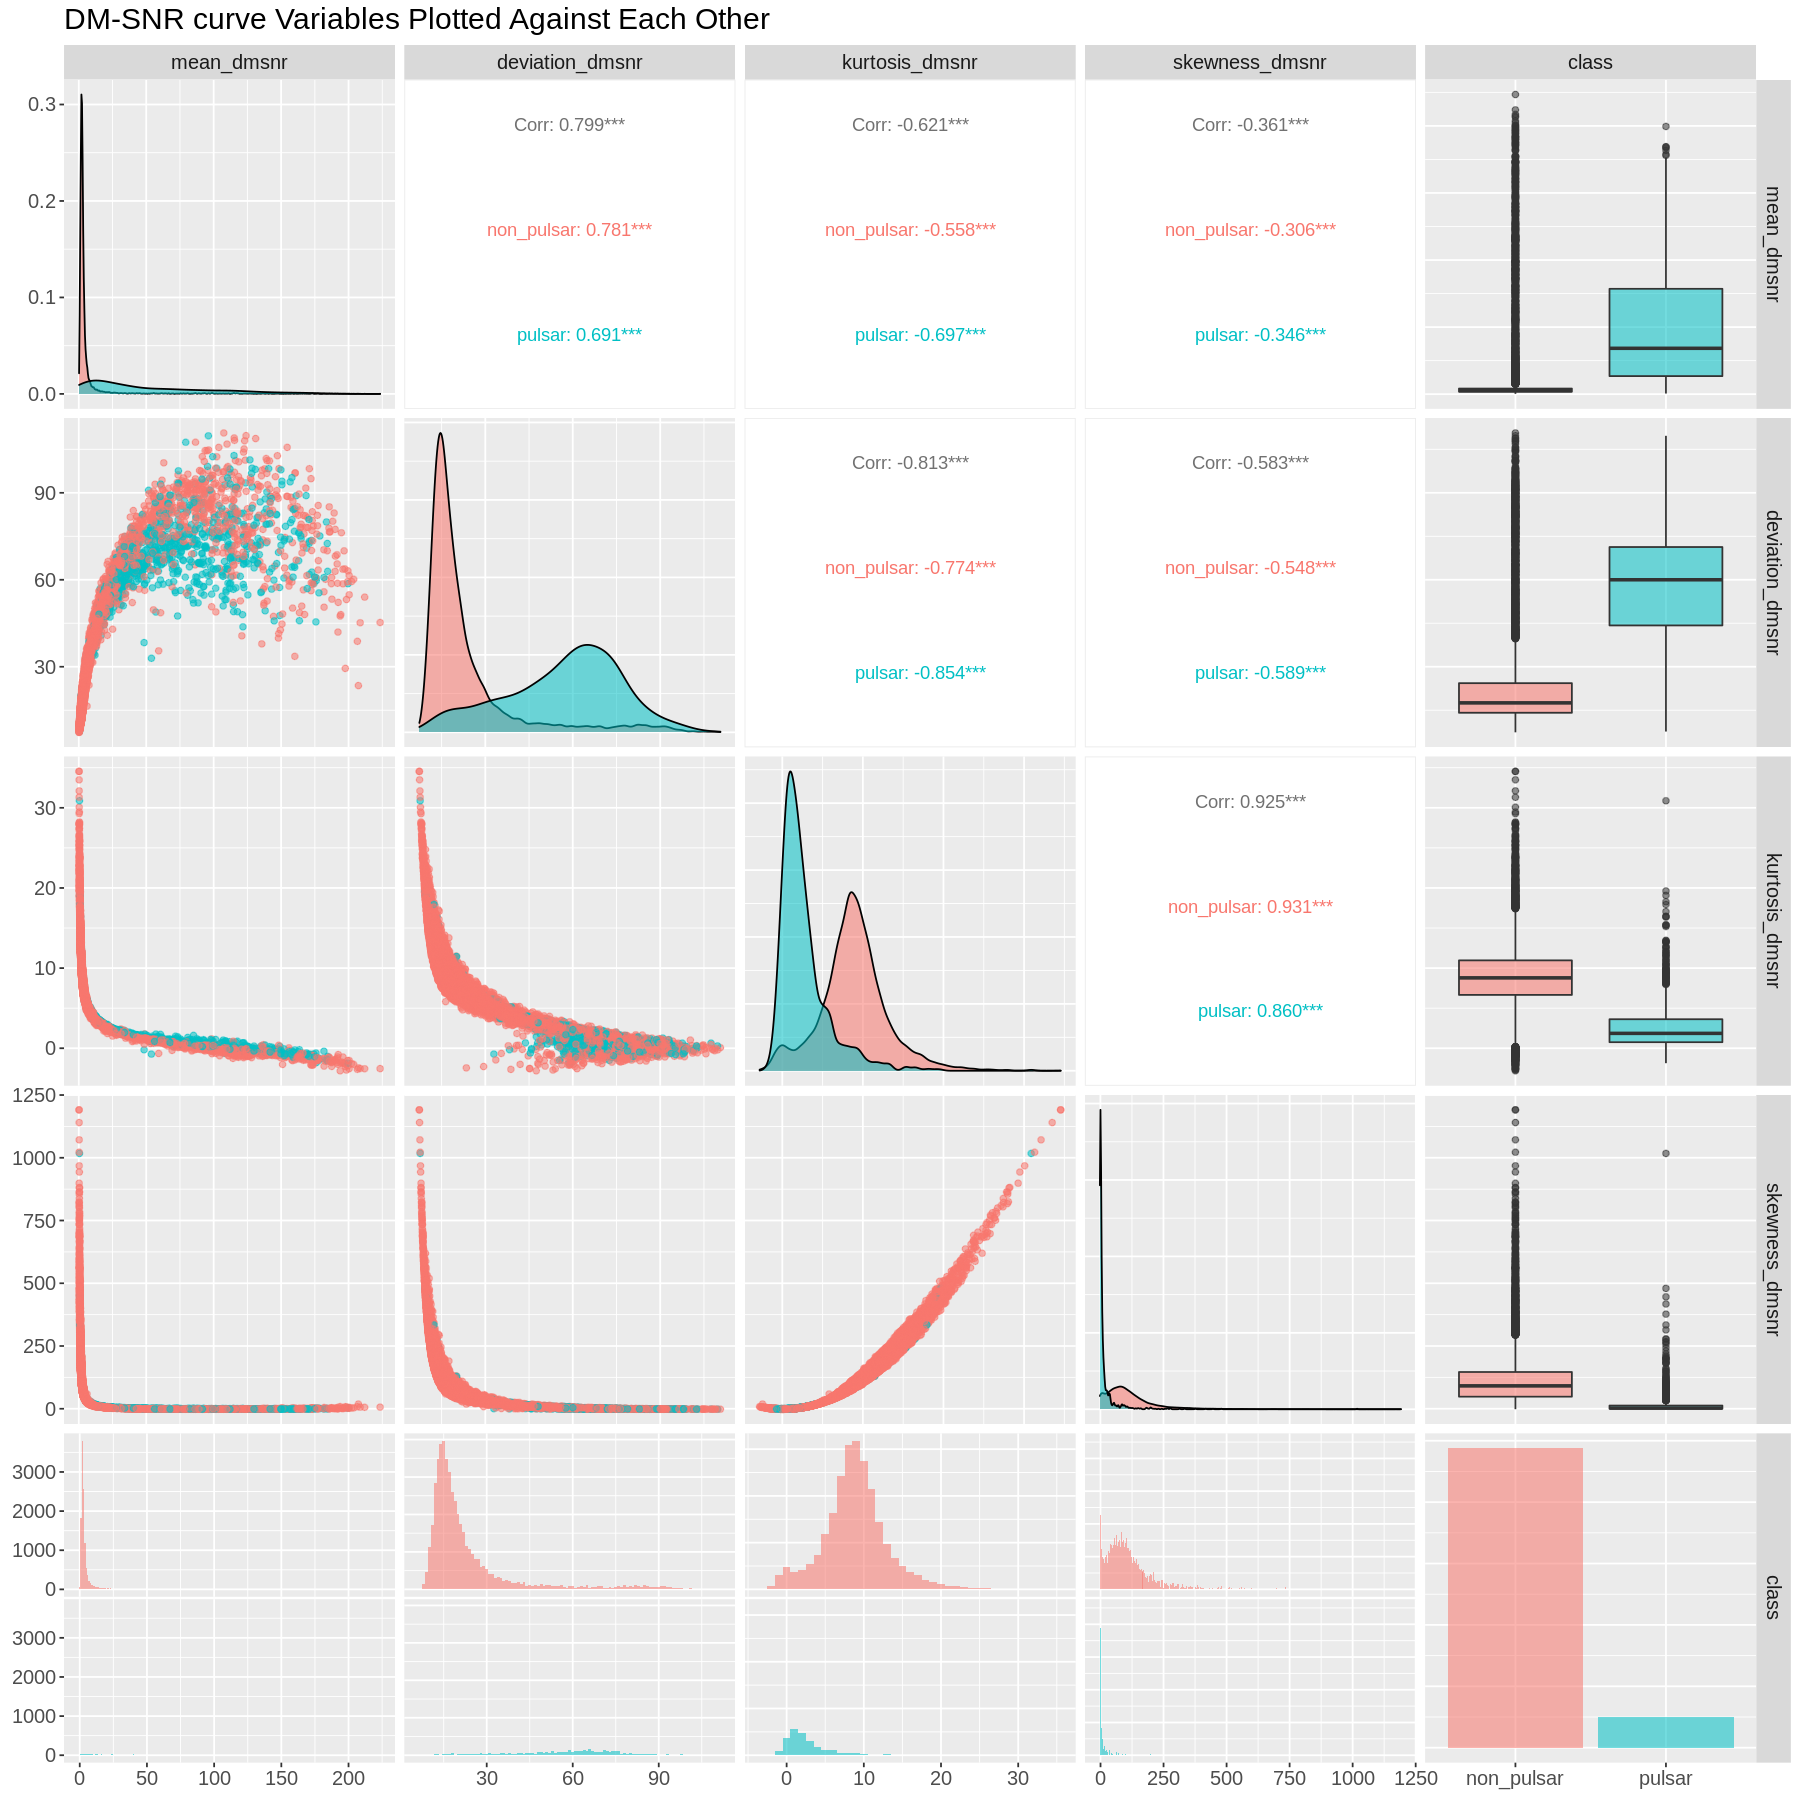

In [13]:
options(repr.plot.width = 15, repr.plot.height = 15)

pulsar_train_dmsnr_plot <- pulsar_train |>
    select(!mean_profile:skewness_profile) |>
    ggpairs(aes(color = class, alpha = 0.5),
            lower = list(combo = wrap("facethist", binwidth = 1))) +
    labs(title = "DM-SNR curve Variables Plotted Against Each Other") +
    theme(text = element_text(size = 15))
pulsar_train_dmsnr_plot

From the ggpairs plots above, the integrated pulse profile variables have a better seperation of pulsar and non-pulsar than the DM-SNR curve variables. Therefore, we will use the 4 integrated pulse profile variables as our predictor variables.

### Visualizing

Scaling the predictor variables.

In [14]:
pulsar_recipe <- recipe(class ~ mean_profile + deviation_profile + kurtosis_profile +
                        skewness_profile, data = pulsar_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

pulsar_train_scaled <- pulsar_recipe |>
    prep() |>
    bake(pulsar_train)

pulsar_train_scaled |> head(6)

mean_profile,deviation_profile,kurtosis_profile,skewness_profile,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.1541500,1.33567710,-0.67244871,-0.4030815,non_pulsar
-0.3297786,1.80190466,-0.01373257,-0.3729926,non_pulsar
-0.3099766,-1.04631457,-0.14736932,-0.1176466,non_pulsar
1.0054830,1.55353627,-0.51606668,-0.3927438,non_pulsar
-0.8671734,-0.85237288,0.11384128,-0.1058551,non_pulsar
-0.6782931,0.02594671,0.04893693,-0.2210799,non_pulsar


Plotting the scaled predictor variables against each other.

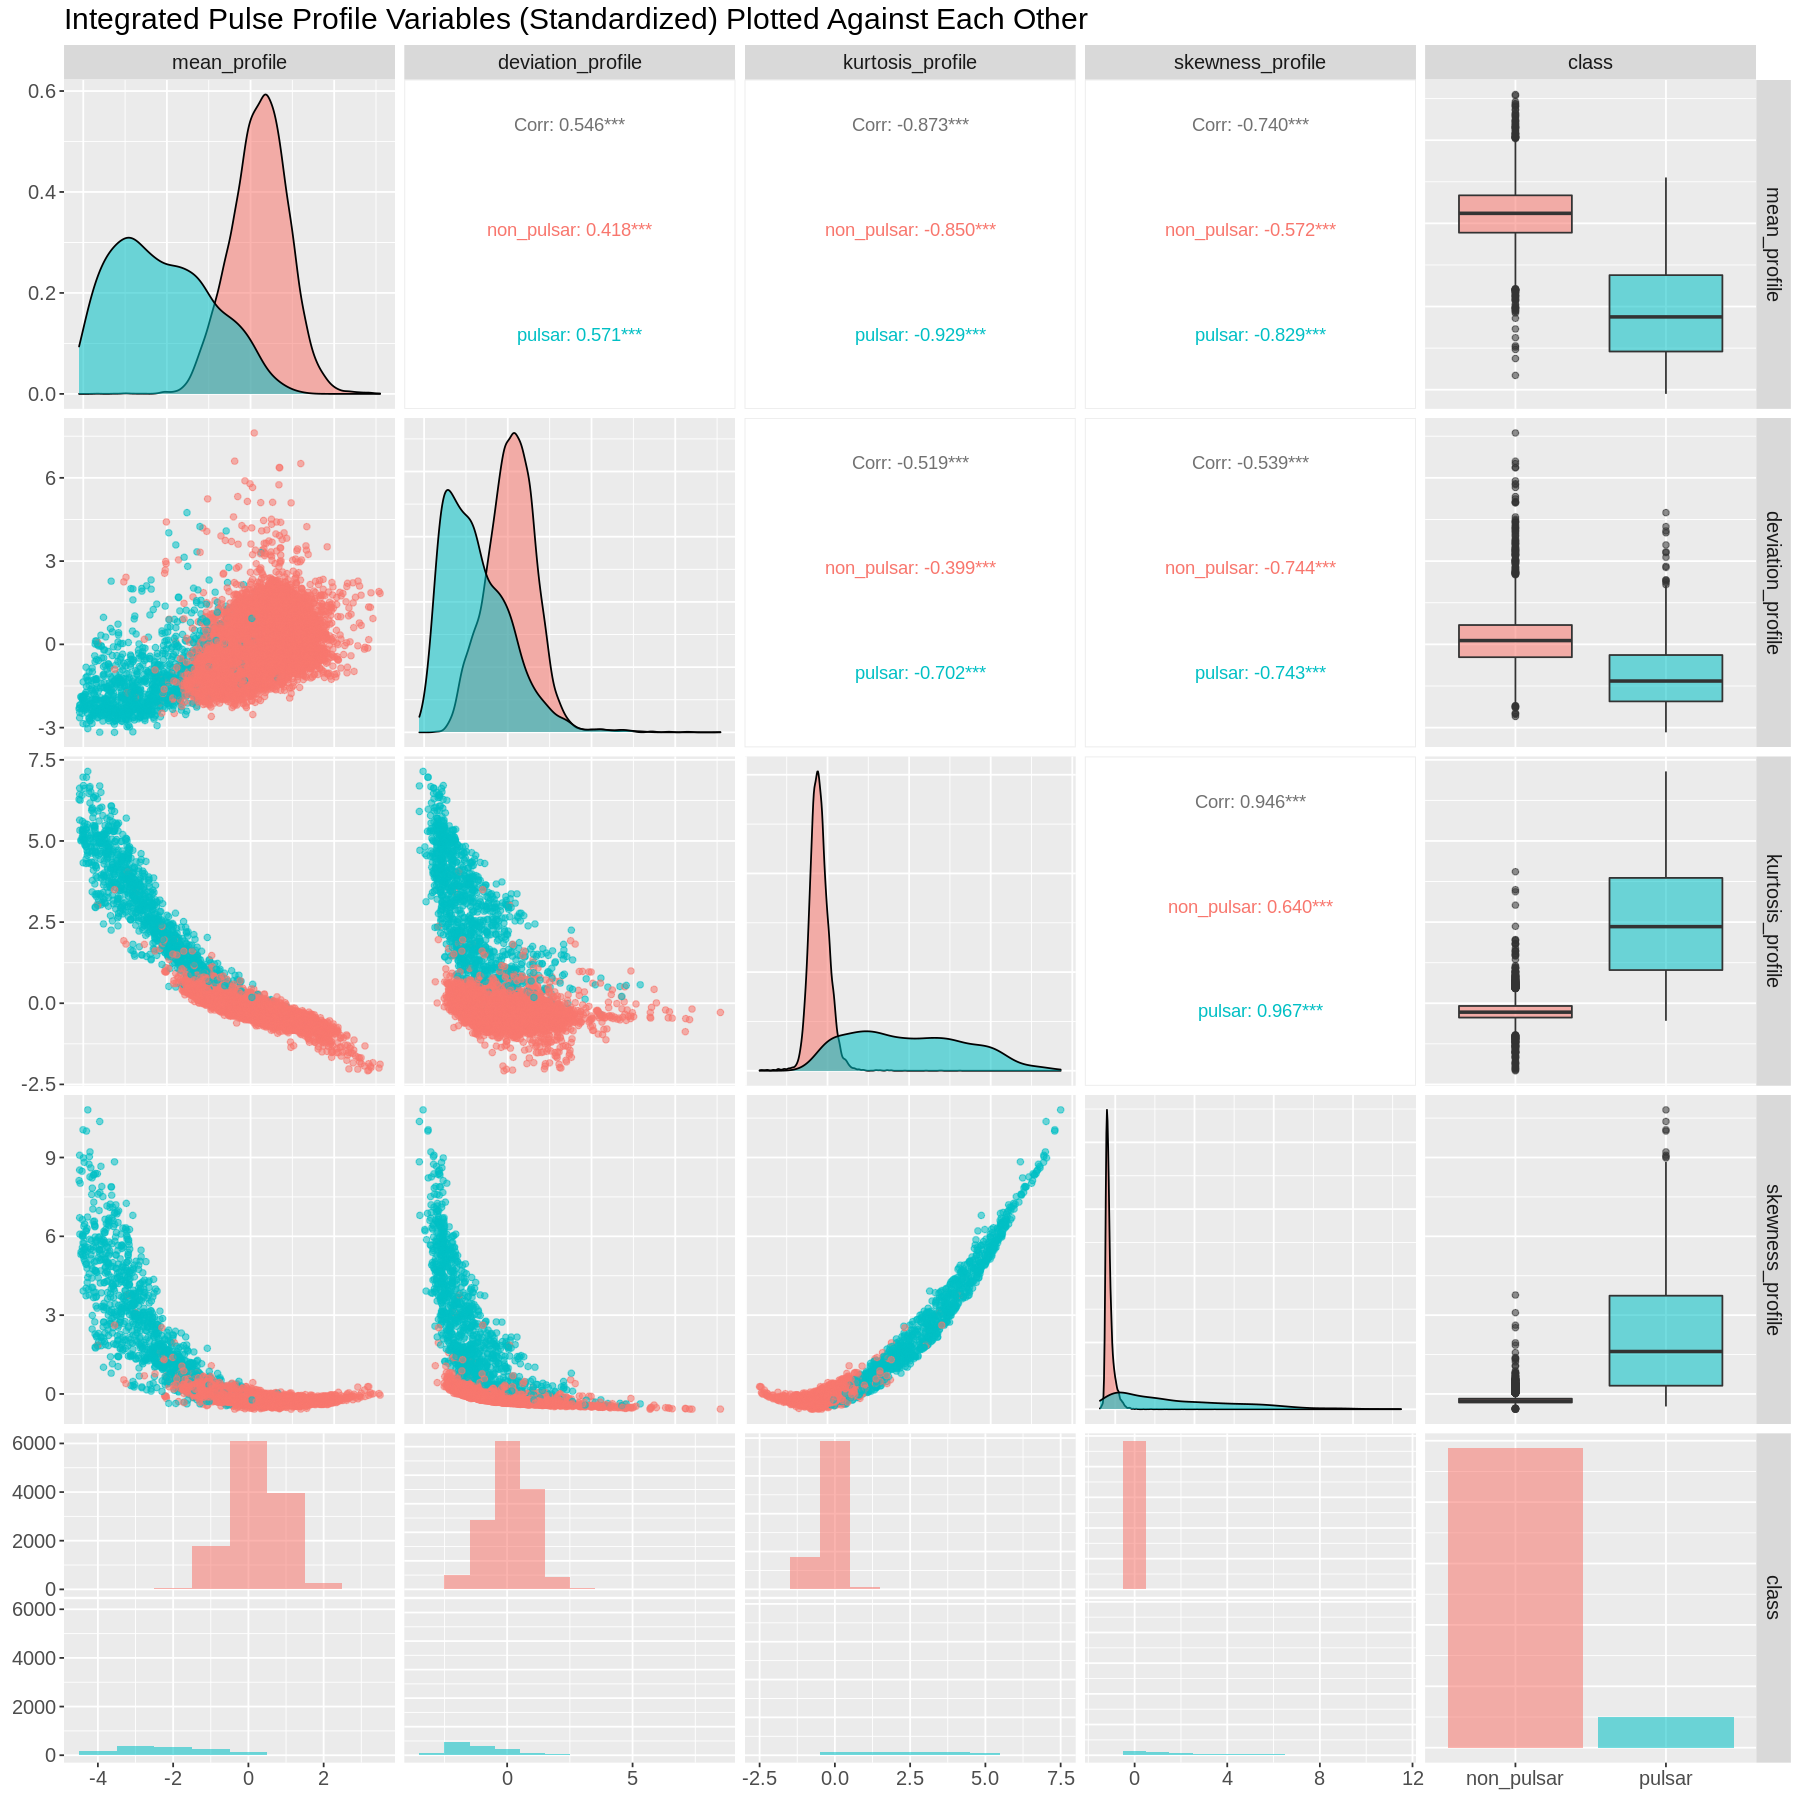

In [15]:
options(repr.plot.width = 15, repr.plot.height = 15)

pulsar_train_scaled_plot <- pulsar_train_scaled |>
    ggpairs(aes(color = class, alpha = 0.5),
            lower = list(combo = wrap("facethist", binwidth = 1))) +
    labs(title = "Integrated Pulse Profile Variables (Standardized) Plotted Against Each Other") +
    theme(text = element_text(size = 15))
pulsar_train_scaled_plot

## Methods

The following 4 variables will be use as our predictor variables: `mean_profile`, `deviation_profile`, `kurtosis_profile`, and `skewness_profile`.

We will use the k-nearest neighbors algorithm to build the classification model. We will tune and cross-validate to find the best representation of the accuracy of each K and determine the best value of K to use for the model. We will then build the model by training and testing it with the best value of K obtained.

We are planning to visualize the results of the model by utilizing a scatter plot that is coloured with the correctness of the model for each observation. This will come with an accuracy percentage of the model.

## Expected outcomes and significance

We expect to be able to classify observed signals as coming from a pulsar star or not to the highest degree of accuracy and precision as possible by also using our findings of the best value of K.

##### Impact of findings

These findings could help lead to scientific breakthroughs in the fields of physics and astronomy, as scientists observe pulsars for research involving gravity and nuclear physics.

##### Future questions

Our model could lead to future questions involving more specific details of stars that are classified as pulsars, such as whether these stars can be classifed by other categories such as age.

## Citations

R. J. Lyon, HTRU2, DOI: 10.6084/m9.figshare.3080389.v1.

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656